In [74]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as onp

import jax.numpy as np
import jax.random as random
from jax import vmap
from jax.config import config as jax_config

import numpyro.distributions as dist
from numpyro.handlers import sample, seed, substitute, trace
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import mcmc

import torch

In [75]:
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [76]:
A = 1.2
b = -0.3
sigma = 0.2
N = 100

In [77]:
onp.random.seed(0)
X = torch.from_numpy(uniform.rvs(size=N))
X.detach()
X = X.float()

In [78]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma, size=N)).float()

In [79]:
y = A*X + b + e

In [80]:
y.detach()
y = y.float()

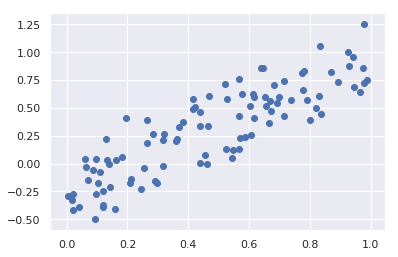

In [81]:
plt.scatter(X.numpy(), y.numpy())

In [82]:
def nonlin(x):
    return np.tanh(x)

In [83]:
def model(X, Y, D_H):
    D_X, D_Y = X.shape[1], 1

    # sample first layer (we put unit normal priors on all weights)
    w1 = sample("w1", dist.Normal(np.zeros((D_X, D_H)), np.ones((D_X, D_H))))  # D_X D_H
    b1 = sample("b1", dist.Normal(np.zeros((D_X, D_H)), np.ones((D_X, D_H))))
    z1 = np.matmul(X, w1) + b1  # N D_H  <= first layer of activations

    # we put a prior on the observation noise
    prec_obs = sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / np.sqrt(prec_obs)

    # observe data
    sample("Y", dist.Normal(z1, sigma_obs), obs=Y)


In [84]:
# helper function for HMC inference
def run_inference(model, rng, X, Y, D_H):
    init_params, potential_fn, constrain_fn = initialize_model(rng, model, X, Y, D_H)
    samples = mcmc(0, 500 , init_params,
                   sampler='hmc', potential_fn=potential_fn, constrain_fn=constrain_fn)
    return samples

In [86]:
rng, rng_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, rng, X.unsqueeze(1).numpy(), y.unsqueeze(1).numpy(), 1)

sample: 100%|██████████| 500/500 [00:08<00:00, 58.35it/s, 1 steps of size 1.25e-01. acc. prob=0.04]




                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b1[0,0]     -0.21      0.20     -0.25     -0.37     -0.20     19.21      1.07
  prec_obs     14.41      3.67     14.28     12.92     19.24      8.44      1.02
   w1[0,0]      1.09      0.36      1.18      1.07      1.41     18.01      1.05




In [71]:
samples.keys()

dict_keys(['b1', 'prec_obs', 'w1'])

In [72]:
w1_samples = samples['w1']
b1_samples = samples['b1']

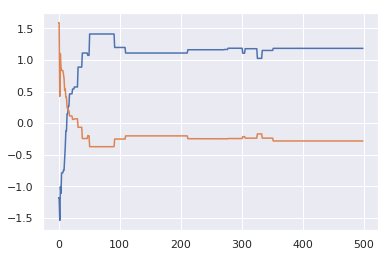

In [73]:
plt.plot(w1_samples.squeeze(-2))
plt.plot(b1_samples.squeeze(-2))

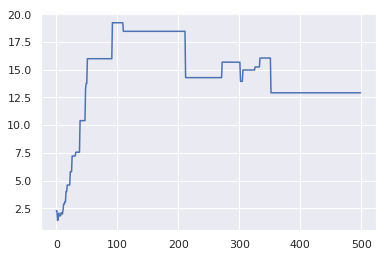

In [57]:
plt.plot(samples['prec_obs'])

NameError: name 'poutine' is not defined

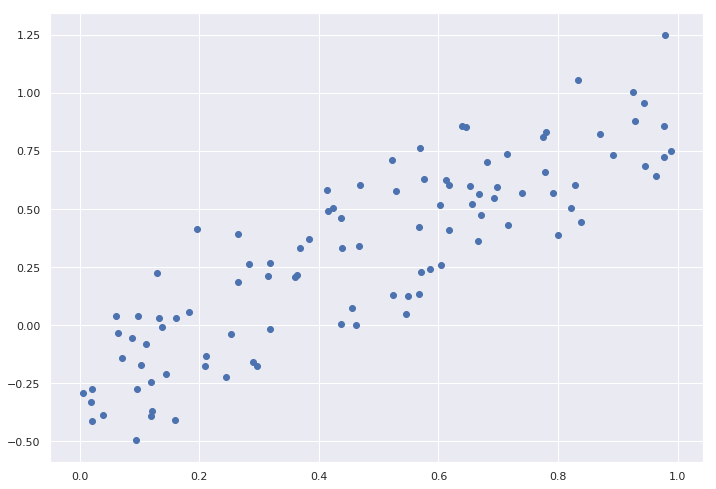

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(X,y)
for _ in range(1000):
    guide_trace = poutine.trace(guide).get_trace(x_test, None)
    lifted_reg_model = poutine.replay(model, guide_trace)
    y_test = lifted_reg_model(x_test, None)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.005, linewidth=1, color='lightblue')